<a href="https://colab.research.google.com/github/fatimaabuhamdeh/AI/blob/main/ML_Lab_Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.utils import plot_model
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error

In [2]:
# read the dataset
Data=pd.read_csv("/content/NFLX.csv")
Data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [3]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5044 non-null   object 
 1   Open       5044 non-null   float64
 2   High       5044 non-null   float64
 3   Low        5044 non-null   float64
 4   Close      5044 non-null   float64
 5   Adj Close  5044 non-null   float64
 6   Volume     5044 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 276.0+ KB


Only the 2020 to 2021 data will be used for training, the data before this time is found to be useless in making the prediction 2021 afterwards

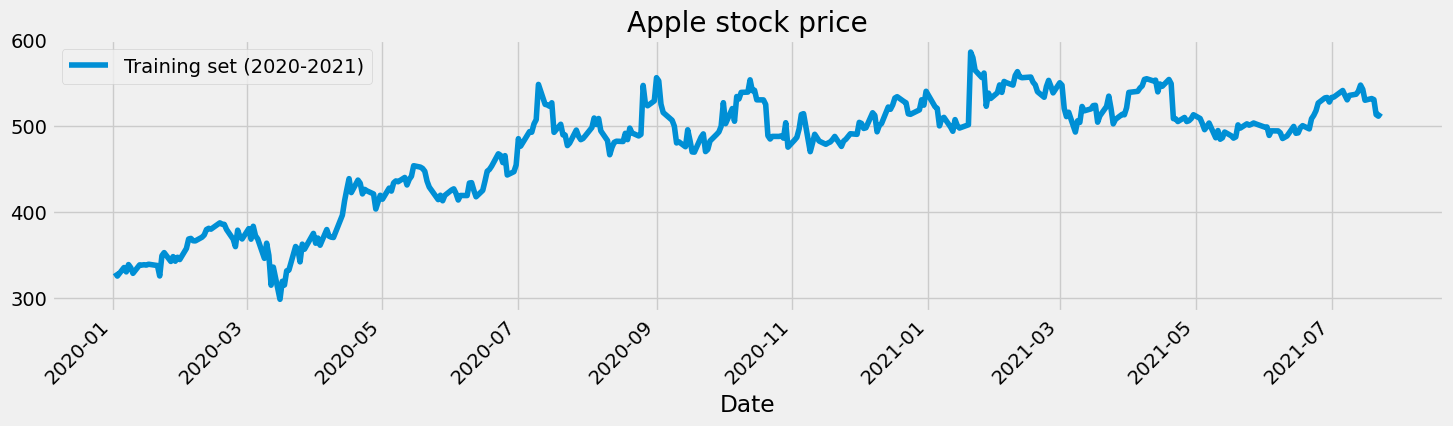

In [4]:

# Convert the 'Date' column to datetime
Data['Date'] = pd.to_datetime(Data['Date'], format='%Y-%m-%d')

# Set the 'Date' column as the index
Data.set_index('Date', inplace=True)

# Plotting
plt.figure(figsize=(10, 5))
Data['Close']['2020':'2021-07-25'].plot(figsize=(16, 4), legend=True)
plt.xticks(rotation=45)
plt.legend(['Training set (2020-2021)'])
plt.title('Apple stock price')
plt.show()


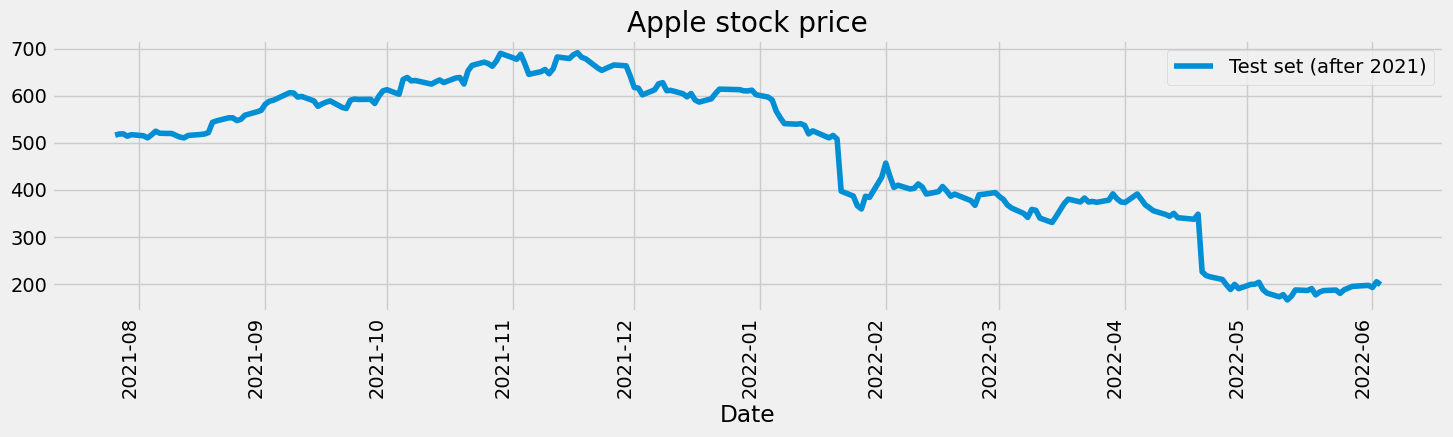

In [5]:
Data['Close']['2021-07-25':].plot(figsize=(16,4),legend=True)
plt.xticks(rotation=90)
plt.legend(['Test set (after 2021)'])
plt.title('Apple stock price')
plt.show()

In [6]:
#Extract High column data
Train_set=Data['Close']['2020-03-10':'2021-07-25'].values
Test_set=Data['Close']['2021-07-25':].values
S=MinMaxScaler()
scaled_train=S.fit_transform(Train_set.reshape(-1,1))
scaled_test=S.transform(Test_set.reshape(-1,1))

Because RNNs work on sequence, inorder to predict on the test set, the model must see the data from the train set, last 20 data from train set will be used to predict the first data point of the test set

In [7]:
Test_set_to_prediction=np.concatenate([scaled_train[-21:],scaled_test],axis=0)


In [8]:
print (Train_set)

[364.130005 349.920013 315.25     336.299988 298.839996 319.75
 315.470001 332.029999 332.829987 360.269989 357.320007 342.390015
 362.98999  357.119995 370.959991 375.5      364.079987 370.079987
 361.76001  379.959991 372.279999 371.119995 370.720001 396.720001
 413.549988 426.75     439.170013 422.959991 437.48999  433.829987
 421.420013 426.700012 424.98999  421.380005 403.829987 411.890015
 419.850006 415.269989 428.149994 424.679993 434.26001  436.529999
 435.549988 440.519989 431.820007 438.269989 441.950012 454.190002
 452.579987 451.040009 447.670013 436.25     429.320007 414.769989
 419.890015 413.440002 419.730011 425.920013 427.309998 421.970001
 414.329987 419.600006 419.48999  434.049988 434.480011 425.559998
 418.070007 425.5      436.130005 447.769989 449.869995 453.720001
 468.040009 466.26001  457.850006 465.910004 443.399994 447.23999
 455.040009 485.640015 476.890015 493.809998 493.160004 502.779999
 507.76001  548.72998  525.5      524.880005 523.26001  527.390015


Generate the sequence data




In [9]:
window_size = 3
def windowed_dataset(series,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series.reshape(-1,1))

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Create batches of windows
    dataset = dataset.batch(len(series)).prefetch(1)
    return dataset

In [10]:
X,y=np.array(list(windowed_dataset(scaled_train,10))[0][0]),np.array(list(windowed_dataset(scaled_train,10))[0][1])

In [11]:
print (X)
print(y)

[[[0.22709566]
  [0.17766961]
  [0.05707827]]

 [[0.17766961]
  [0.05707827]
  [0.13029561]]

 [[0.05707827]
  [0.13029561]
  [0.        ]]

 ...

 [[0.80511296]
  [0.81196524]
  [0.80768684]]

 [[0.81196524]
  [0.80768684]
  [0.7470956 ]]

 [[0.80768684]
  [0.7470956 ]
  [0.74062598]]]
[[0.13029561]
 [0.        ]
 [0.07273044]
 [0.05784349]
 [0.11544348]
 [0.11822604]
 [0.21366952]
 [0.20340871]
 [0.15147831]
 [0.22313039]
 [0.20271302]
 [0.25085213]
 [0.26664346]
 [0.22692168]
 [0.24779125]
 [0.2188522 ]
 [0.28215647]
 [0.25544346]
 [0.25140867]
 [0.25001738]
 [0.34045215]
 [0.39899123]
 [0.44490431]
 [0.48810435]
 [0.43172168]
 [0.4822608 ]
 [0.46953035]
 [0.42636523]
 [0.44473044]
 [0.43878254]
 [0.42622607]
 [0.36518254]
 [0.39321741]
 [0.42090434]
 [0.40497385]
 [0.44977386]
 [0.43770429]
 [0.47102608]
 [0.4789217 ]
 [0.47551296]
 [0.49279992]
 [0.46253912]
 [0.48497384]
 [0.49777392]
 [0.54034779]
 [0.53474774]
 [0.52939129]
 [0.51766957]
 [0.47794779]
 [0.45384347]
 [0.40323471

In [12]:
X_test,y_test=np.array(list(windowed_dataset(Test_set_to_prediction,10))[0][0]),np.array(list(windowed_dataset(Test_set_to_prediction,10))[0][1])

In [13]:
Model1=Sequential(
[
    LSTM(units=60,input_shape=(X.shape[1],1),return_sequences=True),
    LSTM(units=50,return_sequences=True),
    LSTM(units=30,return_sequences=True),
    LSTM(units=20,return_sequences=True),
    LSTM(10),
    Dense(units=1),
])

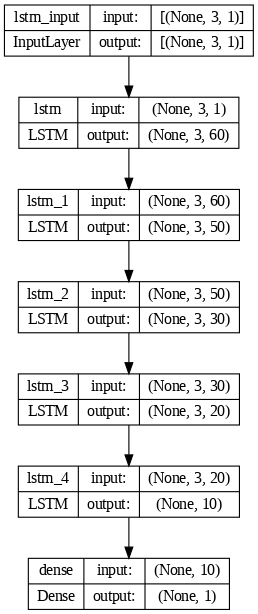

In [15]:
plot_model(Model1, show_shapes = True,expand_nested = True,dpi = 80)


In [16]:
Model1.compile(optimizer = "adam",loss='mean_squared_error')


In [17]:
Model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 60)             14880     
                                                                 
 lstm_1 (LSTM)               (None, 3, 50)             22200     
                                                                 
 lstm_2 (LSTM)               (None, 3, 30)             9720      
                                                                 
 lstm_3 (LSTM)               (None, 3, 20)             4080      
                                                                 
 lstm_4 (LSTM)               (None, 10)                1240      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 52131 (203.64 KB)
Trainable params: 52131 

In [18]:
callbacks=tf.keras.callbacks.ModelCheckpoint(
    'Model.keras',
    monitor= 'loss',
    save_best_only=True)
history= Model1.fit(X,y,epochs=50,callbacks=[callbacks])

Epoch 1/50
11/11 [==============================] - 9s 21ms/step - loss: 0.4407
Epoch 2/50
11/11 [==============================] - 0s 17ms/step - loss: 0.3394
Epoch 3/50
11/11 [==============================] - 0s 17ms/step - loss: 0.1484
Epoch 4/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0305
Epoch 5/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0200
Epoch 6/50
11/11 [==============================] - 0s 26ms/step - loss: 0.0199
Epoch 7/50
11/11 [==============================] - 0s 26ms/step - loss: 0.0170
Epoch 8/50
11/11 [==============================] - 0s 24ms/step - loss: 0.0157
Epoch 9/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0140
Epoch 10/50
11/11 [==============================] - 0s 28ms/step - loss: 0.0122
Epoch 11/50
11/11 [==============================] - 0s 27ms/step - loss: 0.0108
Epoch 12/50
11/11 [==============================] - 0s 25ms/step - loss: 0.0091
Epoch 13/50
11/11 [==================

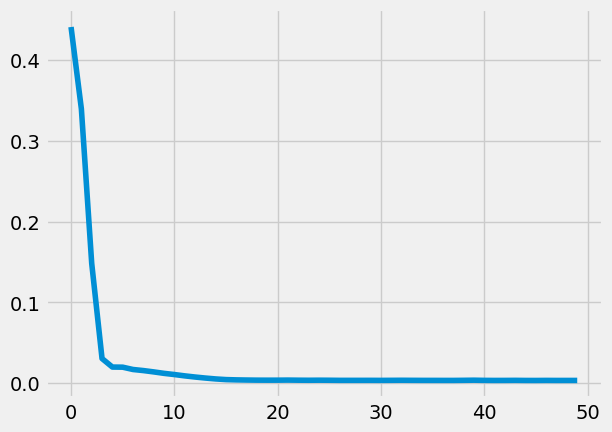

In [19]:
plt.plot(history.history['loss'])

In [20]:
Output1=Model1.predict(X_test)

8/8 [==============================] - 2s 5ms/step


In [21]:
Model1.evaluate(y_test,Output1)

8/8 [==============================] - 2s 4ms/step - loss: 0.4376


0.4376068413257599

In [22]:
mean_squared_error(y_test,Output1)

0.04002658337738667

In [23]:
mean_squared_error(S.inverse_transform(y_test),S.inverse_transform(Output1))

3308.4483796650525

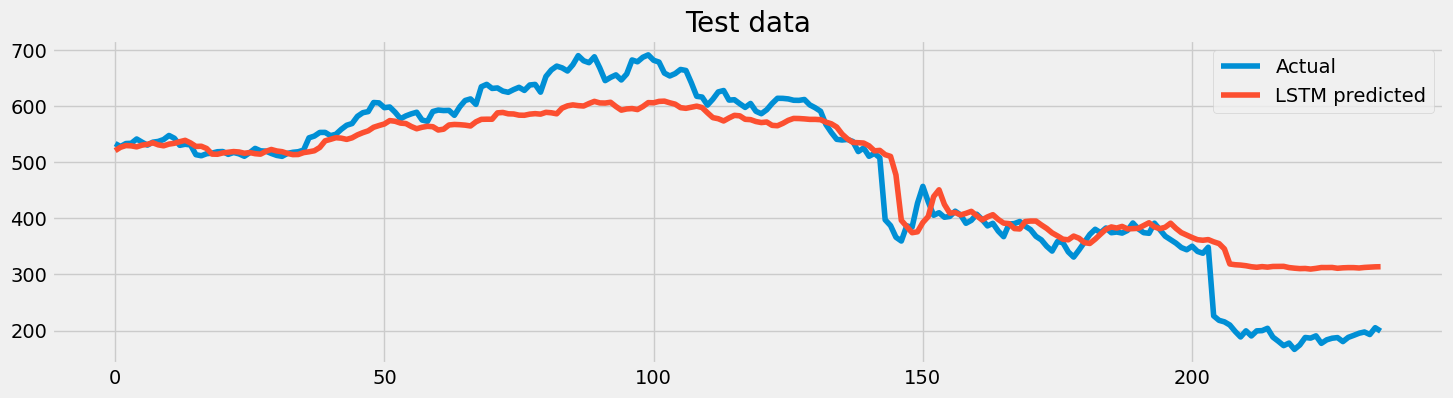

In [24]:
x=np.arange(0,len(y_test))
plt.figure(figsize=(16,4))
plt.title("Test data",fontsize=20)
plt.plot(x,S.inverse_transform(y_test),label="Actual")
plt.plot(x,S.inverse_transform(Output1),label="LSTM predicted")
plt.legend()
plt.show()

In [25]:
Out=Model1.predict(X)

11/11 [==============================] - 0s 6ms/step


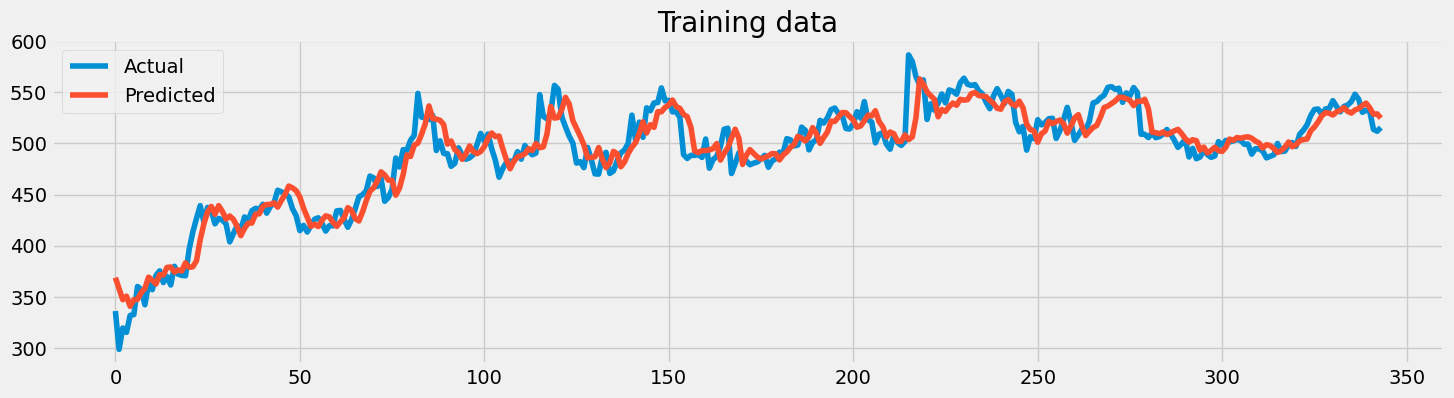

In [26]:
q=np.arange(0,len(y))
plt.figure(figsize=(16,4))
plt.title("Training data",fontsize=20)
plt.plot(q,S.inverse_transform(y),label='Actual')
plt.plot(q,S.inverse_transform(Out),label='Predicted')
plt.legend()
plt.show()

Simple Dense Layer


In [27]:
Model2=Sequential(
[
    Dense(units=30,input_shape=(X.shape[1],1),activation='relu'),
    Dense(units=20,activation='relu'),
    Dense(units=10),
    Dense(units=1)
])

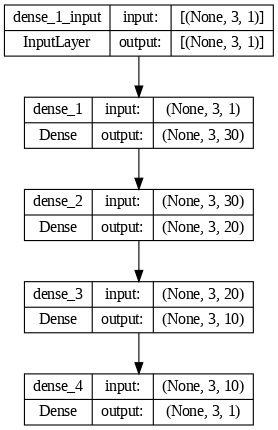

In [28]:
plot_model(Model2, show_shapes = True,expand_nested = True,dpi = 80)


In [29]:
Model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3, 30)             60        
                                                                 
 dense_2 (Dense)             (None, 3, 20)             620       
                                                                 
 dense_3 (Dense)             (None, 3, 10)             210       
                                                                 
 dense_4 (Dense)             (None, 3, 1)              11        
                                                                 
Total params: 901 (3.52 KB)
Trainable params: 901 (3.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
Model2.compile(optimizer='adam',loss='mse')


In [31]:
history2=Model2.fit(X,y,epochs=100,callbacks=[callbacks])

Epoch 1/100
11/11 [==============================] - 1s 3ms/step - loss: 0.4692
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.3583
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2564
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1492
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0644
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0196
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 8/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 10/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 11/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 12/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 13/100
11/11 [=================

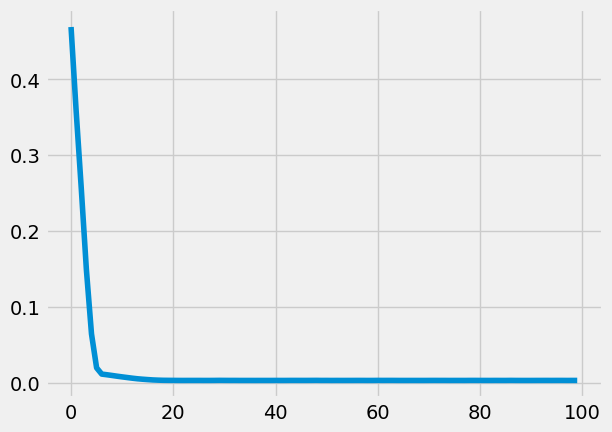

In [32]:
plt.plot(history2.history['loss'])

In [33]:
Output2=Model2.predict(X_test)

8/8 [==============================] - 0s 2ms/step


In [34]:
Model2.evaluate(y_test,Output2)

8/8 [==============================] - 0s 2ms/step - loss: 0.0031


0.0031181478407233953

In [40]:
mean_squared_error(S.inverse_transform(y_test),S.inverse_transform(y_test.reshape(-1,1)))

0.0

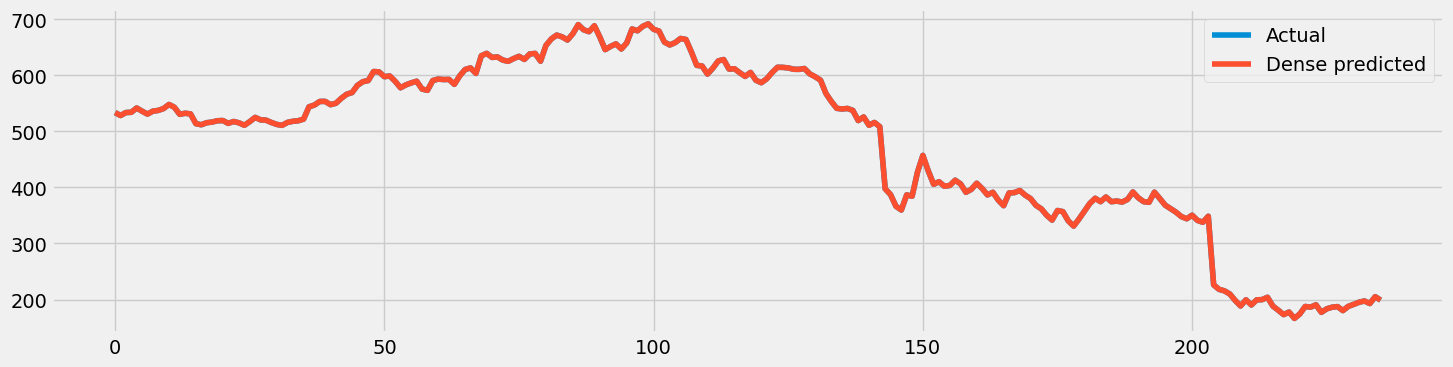

In [42]:
x=np.arange(0,len(y_test))
plt.figure(figsize=(16,4))
plt.plot(x,S.inverse_transform(y_test),label="Actual")
plt.plot(x,S.inverse_transform(y_test.reshape(-1,1)),label="Dense predicted")
plt.legend()
plt.show()